In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishingemails/Phishing_Email.csv


# 1| Download the dataset

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d subhajournal/phishingemails

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/subhajournal/phishingemails
License(s): GNU Lesser General Public License 3.0
 89%|█████████████████████████████████▋    | 16.0M/18.0M [00:01<00:00, 21.7MB/s]
100%|██████████████████████████████████████| 18.0M/18.0M [00:01<00:00, 13.5MB/s]


In [3]:
!unzip /content/phishingemails.zip

unzip:  cannot find or open /content/phishingemails.zip, /content/phishingemails.zip.zip or /content/phishingemails.zip.ZIP.


# 2| Import Necessary libs

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

2024-07-18 22:41:22.824991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 22:41:22.825107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 22:41:22.961641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 3| Loading our data

In [5]:
df = pd.read_csv("/kaggle/input/phishingemails/Phishing_Email.csv")

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


# 4| Text Preprocessing

In [6]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

** There are 16 rows available that have null values .Let's remove these rows



## 4.1| Drop duplicates and null values

In [7]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [8]:
print("Dimension of the row data:",df.shape)

Dimension of the row data: (17538, 2)


In [9]:
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [10]:
# Create the bar chart
fig = px.bar(df['Email Type'].value_counts(), x=df['Email Type'].value_counts().index, y=df['Email Type'].value_counts().values,
             color=['blue', 'red'], labels={'x': 'Category', 'y': 'Count'},
             title="Categorical Distribution")

# Show the plot
fig.show()

Insigths :

The count of the safe emails is more than that of phishing email so if we see any emails that look like phishing delete

In [11]:
# Create the pie chart
fig_pie = px.pie(df['Email Type'].value_counts(), names=df['Email Type'].value_counts().index,
                 values=df['Email Type'].value_counts().values, title="Categorical Distribution")

# Show the pie chart
fig_pie.show()

## 4.3| Integer Encoding

In [12]:
le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

In [13]:
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",1
1,the other side of * galicismos * * galicismo *...,1
2,re : equistar deal tickets are you still avail...,1
3,\nHello I am your hot lil horny toy.\n I am...,0
4,software at incredibly low prices ( 86 % lower...,0
...,...,...
18644,\nRick Moen a Ã©crit:> > I'm confused. I thou...,1
18645,date a lonely housewife always wanted to date ...,0
18646,request submitted : access request for anita ....,1
18647,"re : important - prc mtg hi dorn & john , as y...",1


## 4.4 Remove hyperlinks, punctuations, extra space

In [14]:
import re

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
df["Email Text"] =df["Email Text"].apply(preprocess_text)

In [15]:
df.head()

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0


# WordCloud

## wordcloud of avaiable stopwords

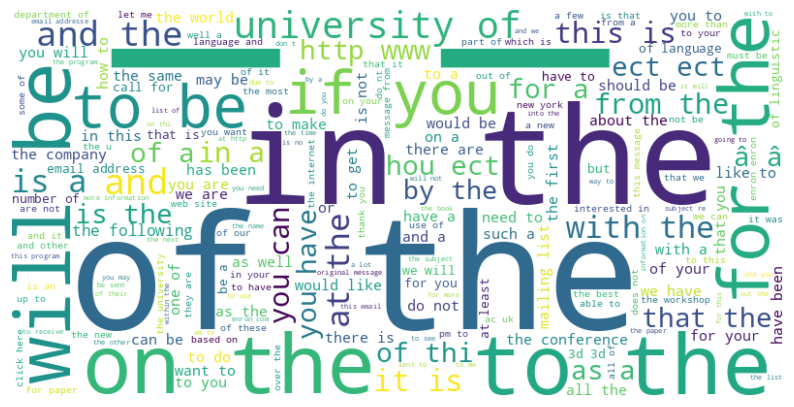

In [16]:
from wordcloud import WordCloud

#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(stopwords="english",width=800,height=400,background_color='white').generate(all_mails)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## wordcloude of unique words

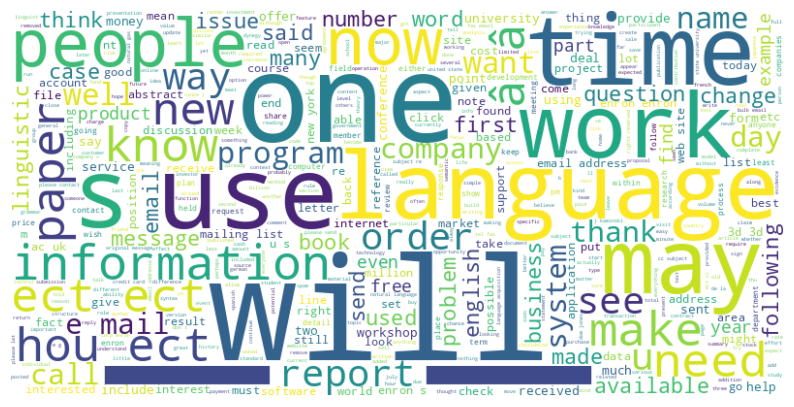

In [17]:
#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=10000).generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## 4.5 Converting text into vector

### 4.5.1 Tfidf vectorizer

In [18]:
tf = TfidfVectorizer(stop_words="english",max_features=10000) #dimension reduction

feature_x = tf.fit_transform(df["Email Text"]).toarray()

In [19]:
y_tf = np.array(df['Email Type']) # convert the label into numpy array

### 4.5.2 Splitting into train and test

In [20]:
x_train,x_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.8,random_state=0)

# 5| Applying different algorithm

## 5.1| Naive Bayes

In [21]:
#naive bayes works with condtional probability
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)

MultinomialNB()

accuracy from native bayes: 97.52 %
f1 score from naive bayes: 97.99 %
classification report :

               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



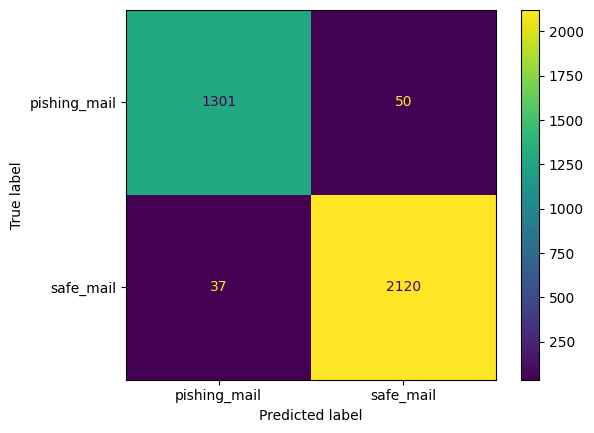

In [22]:
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
pred_nav = nb.predict(x_test)

# Checking the performance

print(f"accuracy from native bayes: {accuracy_score(y_test,pred_nav)*100:.2f} %")
print(f"f1 score from naive bayes: {f1_score(y_test,pred_nav)*100:.2f} %")
print("classification report :\n\n",classification_report(y_test,pred_nav))

#confusion matrix
clf_nav = confusion_matrix(y_test,pred_nav)
cx_ = ConfusionMatrixDisplay(clf_nav,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.2| Logistic Regression


accuracy from logistic regression:97.98 %
f1 score from logistic regression: 98.36 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



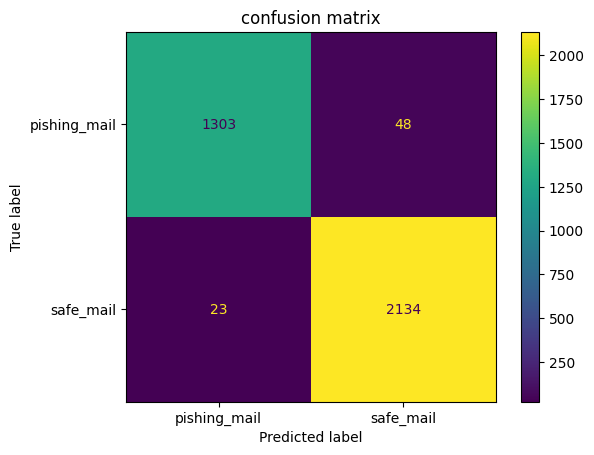

In [23]:
lg = LogisticRegression()
lg.fit(x_train,y_train)

# prediction
pred_lg = lg.predict(x_test)
# performance
print("")
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_lg)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_lg)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_lg))

clf_lg = confusion_matrix(y_test,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

In [24]:
# save the model for future use

import joblib

# Save the trained model to a file
joblib.dump(nb, 'email_spam_nb.pkl')

['email_spam_nb.pkl']

## 5.3| SGD Classifier

accuracy from logistic regression:98.20 %
f1 score from logistic regression: 98.55 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1351
           1       0.98      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



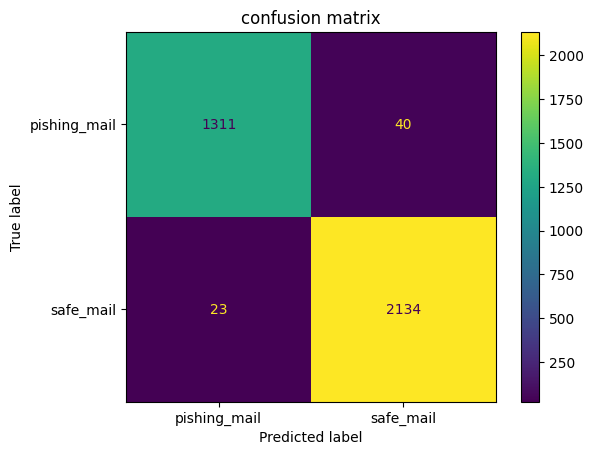

In [25]:
from sklearn.linear_model import SGDClassifier

# passing object
sgd = SGDClassifier()
sgd.fit(x_train,y_train)

# prediction
pred_sgd = sgd.predict(x_test)
# performance
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_sgd)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_sgd)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_sgd))

clf_sgd = confusion_matrix(y_test,pred_sgd)
cx_ = ConfusionMatrixDisplay(clf_sgd,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.4| XGBoost

accuracy from XGB:97.04 %
f1 score from XGB: 97.58 %
classification report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1351
           1       0.98      0.97      0.98      2157

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



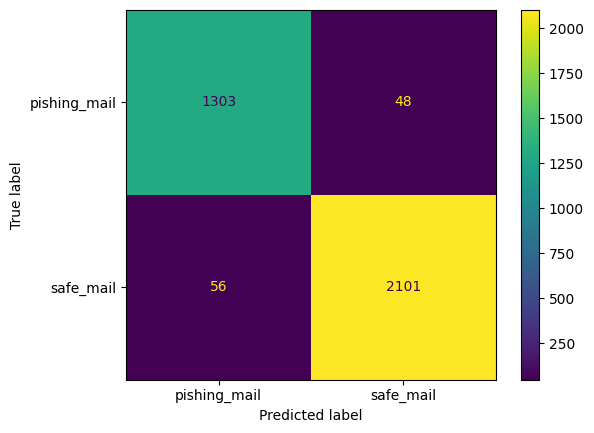

In [26]:
# applying boosting algorithm
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

#prediction
pred_xgb = xgb.predict(x_test)

#performance
print(f"accuracy from XGB:{accuracy_score(y_test,pred_xgb)*100:.2f} %")
print(f"f1 score from XGB: {f1_score(y_test,pred_xgb)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_xgb))

#confusion matrix
clf_xgb = confusion_matrix(y_test,pred_xgb)
cx_ = ConfusionMatrixDisplay(clf_xgb,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.5| Decision Tree

accuracy from Decision Tree:93.13 %
f1 score from Decision Tree: 94.39 %
classification report : 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1351
           1       0.95      0.94      0.94      2157

    accuracy                           0.93      3508
   macro avg       0.93      0.93      0.93      3508
weighted avg       0.93      0.93      0.93      3508



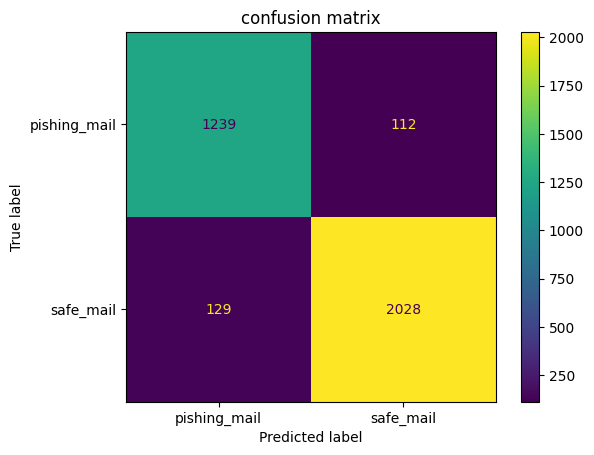

In [27]:
dtr = DecisionTreeClassifier() #passing object
dtr.fit(x_train,y_train)

#prediction
pred_dtr = dtr.predict(x_test)

#performance
print(f"accuracy from Decision Tree:{accuracy_score(y_test,pred_dtr)*100:.2f} %")
print(f"f1 score from Decision Tree: {f1_score(y_test,pred_dtr)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_dtr))

#confusion matrix
clf_dtr = confusion_matrix(y_test,pred_dtr)
cx_ = ConfusionMatrixDisplay(clf_dtr,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.6| Random Forest 

accuracy from rnadom forest:97.72 %
f1 score from random forest: 98.14 %
classification report : 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



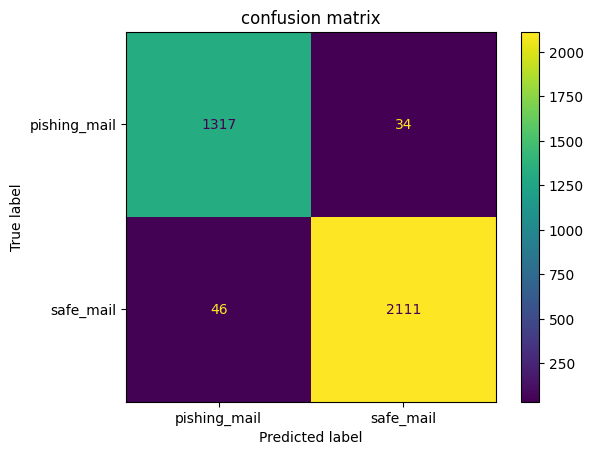

In [28]:
rnf = RandomForestClassifier() #passing object
rnf.fit(x_train,y_train)

#prediction
pred_rnf = rnf.predict(x_test)

#performance
print(f"accuracy from rnadom forest:{accuracy_score(y_test,pred_rnf)*100:.2f} %")
print(f"f1 score from random forest: {f1_score(y_test,pred_rnf)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_rnf))

#confusion matrix
clf_rnf = confusion_matrix(y_test,pred_rnf)
cx_ = ConfusionMatrixDisplay(clf_rnf,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.7| MLP Classifier (Multi-Layer perceptrons)

accuracy from MLP:98.49 %
f1 score from MLP: 98.77 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



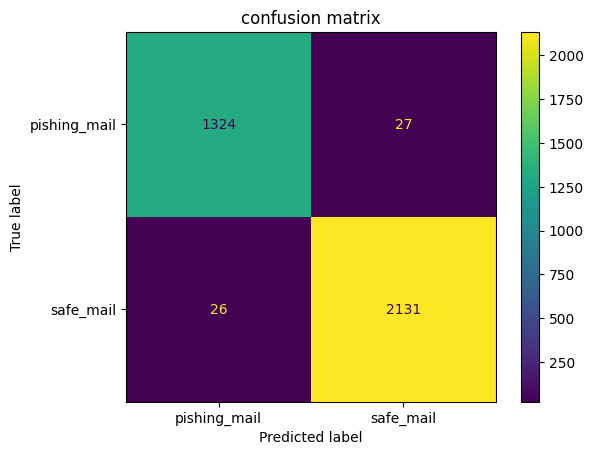

In [29]:
mlp = MLPClassifier()  # passing object
mlp.fit(x_train,y_train)

#prediction
pred_mlp = mlp.predict(x_test)

#performance
print(f"accuracy from MLP:{accuracy_score(y_test,pred_mlp)*100:.2f} %")
print(f"f1 score from MLP: {f1_score(y_test,pred_mlp)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_mlp))

#confusion matrix
clf_mlp = confusion_matrix(y_test,pred_mlp)
cx_ = ConfusionMatrixDisplay(clf_mlp,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.8| EDA comparison of the models performances

In [30]:
models = ['Naive bayes', 'Logistic Regression', 'SGD Classifier', 'XGBoost', 'Decision Tree', 'Random Forest', 'MLPClassifier']
accuracies = [97.52, 97.95, 98.57, 97.21, 93.67, 97.72, 98.29]

# Create the bar chart
fig = px.bar(x=models, y=accuracies, labels={'x': 'Models', 'y': 'Accuracy'},
             title="Performance of the models", text=accuracies)

# Customize the layout (optional)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside', marker_color='magenta')

# Show the plot
fig.show()

# 6| NN (Neural Network)

In [31]:
max_len = 150

tk = Tokenizer()

# Process the text

tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [32]:
len(vector)

17538

In [33]:
x = np.array(vector)
y = np.array(df["Email Type"])

In [34]:
#Split the dataset into train and test set

x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

## 6.1| Simple RNN

In [35]:
model_smp = Sequential() # Sequential() API
model_smp.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_smp.add(SimpleRNN(units=100))
model_smp.add(Dropout(0.45))
model_smp .add(Dense(1, activation='sigmoid'))

In [36]:
model_smp.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [37]:
model_smp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
historical_smp  = model_smp.fit(x_train,y_train, epochs=7, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/7
  7/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4827 - loss: 0.6979

I0000 00:00:1721342889.036009      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721342889.058426      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


877/877 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6000 - loss: 0.6657

W0000 00:00:1721342907.227571      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.6000 - loss: 0.6657 - val_accuracy: 0.6776 - val_loss: 0.5630
Epoch 2/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6567 - loss: 0.6081 - val_accuracy: 0.6605 - val_loss: 0.5530
Epoch 3/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7352 - loss: 0.4838 - val_accuracy: 0.6842 - val_loss: 0.5291
Epoch 4/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7495 - loss: 0.4239 - val_accuracy: 0.6790 - val_loss: 0.5396
Epoch 5/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7306 - loss: 0.4894 - val_accuracy: 0.6613 - val_loss: 0.5939
Epoch 6/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7611 - loss: 0.4184 - val_accuracy: 0.6628 - val_loss: 0.5931
Epoch 7/7
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.7594 - loss: 0.4106 - val_accuracy: 0.6750 - val_loss: 0.6091


Text(0, 0.5, 'Loss')

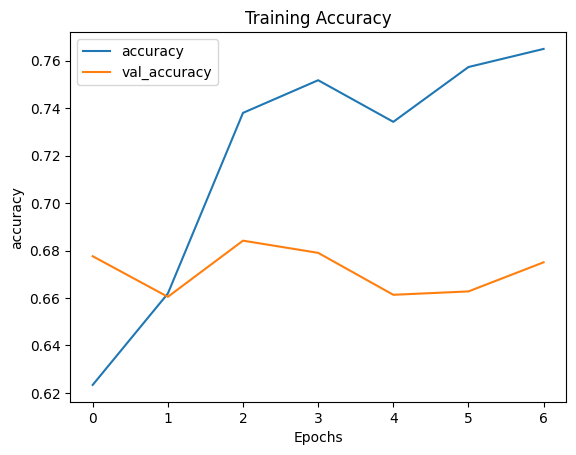

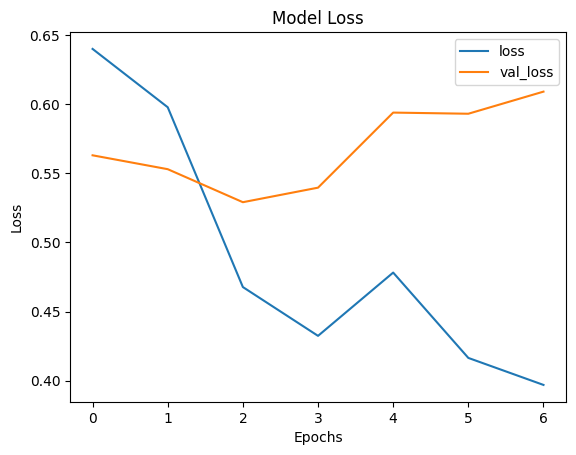

In [39]:
import matplotlib.pyplot as plt
pd.DataFrame(historical_smp.history)

pd.DataFrame(historical_smp.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_smp.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


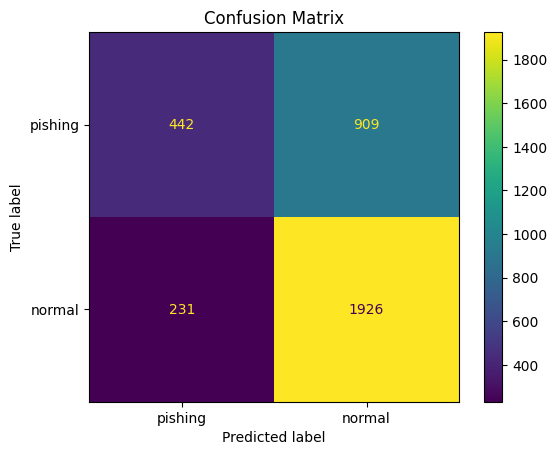

In [40]:
y_pred_prob_smp = model_smp.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['pishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

## 6.2| LSTM Architecture

In [41]:
model = Sequential() # Sequential() API
model.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
historical  = model.fit(x_train,y_train, epochs=5, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.7187 - loss: 0.5446 - val_accuracy: 0.9028 - val_loss: 0.3010
Epoch 2/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9218 - loss: 0.2444 - val_accuracy: 0.8854 - val_loss: 0.2834
Epoch 3/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9317 - loss: 0.1881 - val_accuracy: 0.9689 - val_loss: 0.1191
Epoch 4/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9799 - loss: 0.0669 - val_accuracy: 0.9766 - val_loss: 0.0800
Epoch 5/5
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9954 - loss: 0.0221 - val_accuracy: 0.9712 - val_loss: 0.0951


# 7| Performance

In [45]:
results = model.evaluate(x_test, y_test)
loss = results[0]  # Extract the loss from the results
accuracy = results[1]  # Extract the accuracy from the results

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9708 - loss: 0.0911
Model Loss: 0.09512501955032349
Model Accuracy: 97.12086915969849


In [46]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Text(0, 0.5, 'Loss')

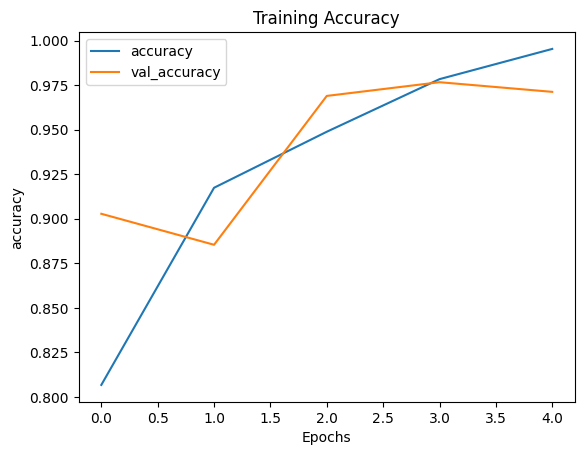

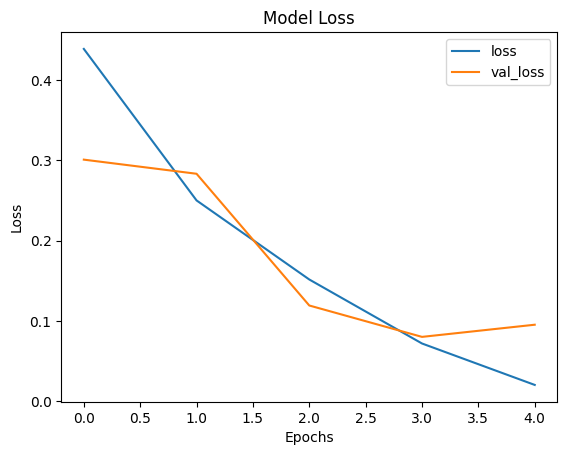

In [47]:
pd.DataFrame(historical.history)

pd.DataFrame(historical.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

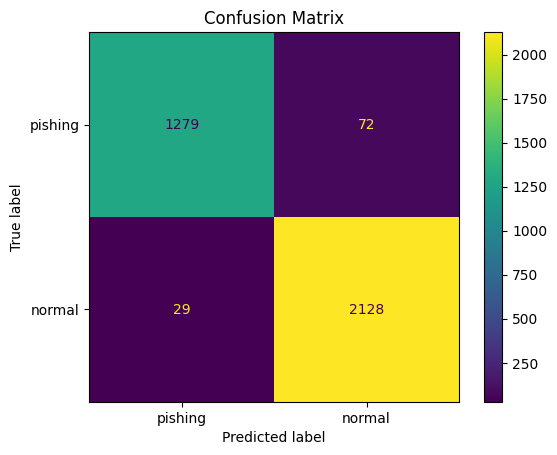

In [48]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

# 8| Bidirectional

In [49]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [50]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [51]:
model_bi.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [52]:
historical  = model_bi.fit(x_train,y_train, epochs=2, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/2
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.8380 - loss: 0.3449 - val_accuracy: 0.9732 - val_loss: 0.0823
Epoch 2/2
877/877 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9840 - loss: 0.0504 - val_accuracy: 0.9652 - val_loss: 0.1007


In [53]:
model_bi.evaluate(x_test,y_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9668 - loss: 0.0960


[0.10071448236703873, 0.9652223587036133]

In [54]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


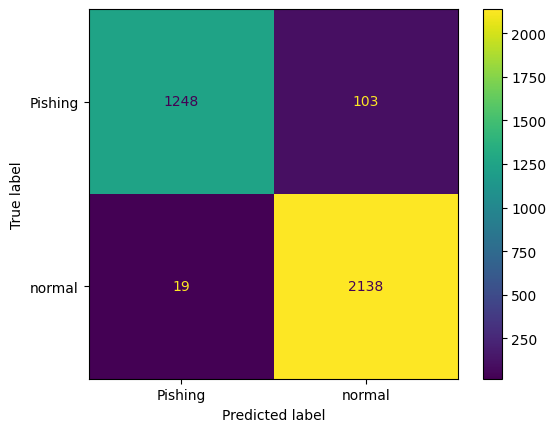

In [55]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Pishing','normal'])
ax_bi.plot()
plt.show()

# 9| GRU (Gated Recurrent Unit)

In [56]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [57]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
model_gru.fit(x_train,y_train, epochs=3, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/3
877/877 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6650 - loss: 0.5906 - val_accuracy: 0.8469 - val_loss: 0.4577
Epoch 2/3
877/877 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9337 - loss: 0.1774 - val_accuracy: 0.9761 - val_loss: 0.0672
Epoch 3/3
877/877 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9937 - loss: 0.0242 - val_accuracy: 0.9792 - val_loss: 0.0675


In [59]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


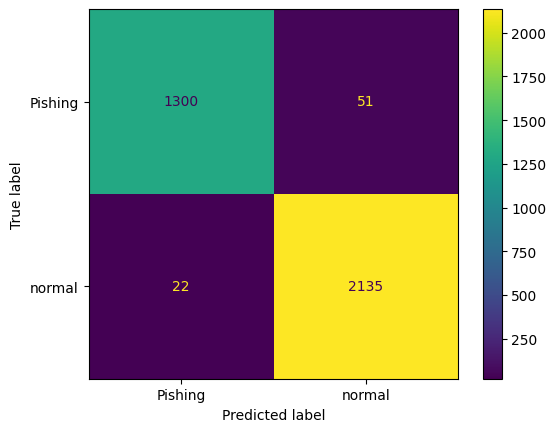

In [60]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['Pishing','normal'])
ax_gru.plot()
plt.show()

### Thanks for watching upvotes ###